This onboarding notebook will demonstrate how to use this codebase. The different sections correspond to different parts of the overall pipeline and also roughly correspond to the different files in `utils`.

Before running this notebook, ensure that your virtual environment is set up and that you have installed the necessary libraries. 

### imports and setup

First, we want to set up the ipython autoreload extension, which autoreloads imported modules every time we run a cell in this notebook, so that any changes elsewhere in the codebase will be up to date when code in this notebook is executed.

In [1]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2

In [2]:
from utils.jraph_data import get_lorenz_graph_tuples, print_graph_fts
from utils.lorenz import load_lorenz96_2coupled

import numpy as np
import jax.numpy as jnp


### CONFIGS

TODO move this to top and reference it instead of magic numbers

Configs are useful for keeping track of the parameters you are using for a particular run. Also, some of the parameters need to be reused between the data generation and the model/training setup, so it's convenient to be able to just reference a config file that contains everything in one place. Here is what an example config looks like and how to call attributes: 

In [3]:
import ml_collections

config = ml_collections.ConfigDict()

# Data params. 
config.n_samples=5000
config.input_steps=1
config.output_delay=0 # predict 0 hours into the future
config.output_steps=4
config.timestep_duration= 3
config.sample_buffer=-1 * (config.input_steps + config.output_delay + config.output_steps - 1) # negative buffer so that our sample input are continuous (i.e. the first sample would overlap a bit with consecutive samples) 
config.time_resolution=120
config.init_buffer_samples=0
config.train_pct=0.7
config.val_pct=0.2
config.test_pct=0.1
config.K=36
config.F=8
config.c=10
config.b=10
config.h=1
config.seed=42
config.normalize=True
config.fully_connected_edges=False

# Optimizer.
config.optimizer = 'adam'
config.learning_rate = 1e-3

# Training hyperparameters.
# config.batch_size = 3
config.epochs = 150
config.log_every_epochs = 5
config.eval_every_epochs = 5
config.checkpoint_every_epochs = 10
config.max_checkpts_to_keep = 2 # None means keep all checkpoints

# GNN hyperparameters.
config.model = 'MLPGraphNetwork'
config.n_blocks = 1
config.activation = 'relu'
config.dropout_rate = 0.1
config.skip_connections = False # This was throwing a broadcast error in add_graphs_tuples_nodes when this was set to True
config.layer_norm = False # TODO perhaps we want to turn on later
config.edge_features = (4, 8) # the last feature size will be the number of features that the graph predicts
config.node_features = (32, 2)
config.global_features = None
config.share_params = False

Then you can simply reference the config's attributes by calling, e.g. 
`some_param_you_want_to_set = config.param_name`

### DATA

In this section we go over how to run the Lorenz simulation, and how to generate the graph data objects. 

#### Lorenz simulation

In [4]:
from utils.lorenz import run_download_lorenz96_2coupled, load_lorenz96_2coupled

Normally, we want to save the Lorenz simulations that we run so that we don't have to repeat the ODE integration if we want to reuse the data. 

The following code runs ODE integration over the coupled 2-layer Lorenz96 model and saves the data to an .npz file. 

In [5]:
run_download_lorenz96_2coupled(
        fname="data/separate_loss", 
        K=config.K,
        F=config.F,
        c=config.c,
        b=config.b,
        h=config.h,
        n_steps=100,
        resolution=config.time_resolution,
        seed=config.seed)

Check that the data folder contains a new .npz file, and that the data_directory.json file now contains a new entry for this simulation run. 

Next, we can load the data: 

In [6]:
t, X = load_lorenz96_2coupled(fname="data/demo.npz")
print(X.shape)
X

FileNotFoundError: [Errno 2] No such file or directory: 'data/demo.npz'

You can play around with different ways to visualize this. (There are some existing functions in utils.visualization but they're kinda a mess right now.)

#### GraphsTuples

In the pipeline to generate data and train the model, you won't actually need to call the Lorenz simulation directly, since it's wrapped in the calls to get the graph data. 

We are using the `GraphsTuple` object defined in the `jraph` library. 

Note here the difference between samples, timesteps, and (simulation) steps. 

TODO insert a visualization of what these are 

In [7]:
from utils.jraph_data import get_lorenz_graph_tuples, print_graph_fts

In [8]:
# generate desired dataset with train/val split and subsampled windows
graph_tuple_dict = get_lorenz_graph_tuples(
    n_samples=config.n_samples,
    input_steps=config.input_steps,
    output_delay=config.output_delay,
    output_steps=config.output_steps,
    timestep_duration=config.timestep_duration,
    sample_buffer=config.sample_buffer,
    time_resolution=config.time_resolution,
    init_buffer_samples=config.init_buffer_samples,
    train_pct=config.train_pct,
    val_pct=config.val_pct,
    test_pct=config.test_pct,
    K=config.K,
    F=config.F,
    c=config.c,
    b=config.b,
    h=config.h,
    seed=config.seed,
    normalize=config.normalize,
    fully_connected_edges=config.fully_connected_edges)

Note the additional parameters for `normalization` and `fully_connected_edges`. If `fully_connected_edges` is False, each node will only be connected to its two nearest neighbors and itself (5 total edges per node). There are some theoretical and practical considerations about which to choose (atm I am not sure what is best – it seems like theoretically fully-connected could be better, but that performed way worse in hyperparameter tuning. Also, Keisler's Graph Weather paper only had edges between adjacent nodes (on a sphere), so it seems like in theory we may not actually need fully-connected?)

Also, (not doing it here, but) it can be helpful to compare the normalized with non-normalized data to check that the pre-processing step is correct. 

example of how to index the graph_tuple_dict object: 

In [9]:
train_dataset = graph_tuple_dict['train']
val_dataset = graph_tuple_dict['val']
test_dataset = graph_tuple_dict['test']

train_inputs = train_dataset['inputs']
train_targets = train_dataset['targets']
val_inputs = val_dataset['inputs']
val_targets = val_dataset['targets']
test_inputs = test_dataset['inputs']
test_targets = test_dataset['targets']

sample_input_window = train_inputs[0]
sample_target_window = train_targets[0]
sample_graph = sample_input_window[0]

print("graph_tuple_dict type:", type(graph_tuple_dict))
print("graph_tuple_dict keys:", graph_tuple_dict.keys())
print("graph_tuple_dict value type:", type(train_dataset))
print("train dataset keys:", train_dataset.keys())
print("train dataset value type:", type(train_inputs))

print("size of train inputs:", len(train_inputs))
print("size of train targets:", len(train_targets))
print("size of val inputs:", len(val_inputs))
print("size of val targets:", len(val_targets))
print("size of test inputs:", len(test_inputs))
print("size of test targets:", len(test_targets))

print("train inputs window type:", type(sample_input_window))
print("train input window size (i.e. input steps per window):", len(sample_input_window))
print("element type in window:", type(sample_graph))

graph_tuple_dict type: <class 'dict'>
graph_tuple_dict keys: dict_keys(['train', 'val', 'test'])
graph_tuple_dict value type: <class 'dict'>
train dataset keys: dict_keys(['inputs', 'targets'])
train dataset value type: <class 'list'>
size of train inputs: 3500
size of train targets: 3500
size of val inputs: 1000
size of val targets: 1000
size of test inputs: 500
size of test targets: 500
train inputs window type: <class 'list'>
train input window size (i.e. input steps per window): 1
element type in window: <class 'jraph._src.graph.GraphsTuple'>


This is an example of what a single GraphsTuple object looks like (representing the state of the system at a single instant in time). (It's terrible to scroll through, would recommend collapsing). Below are better ways to index through the object.

In [160]:
print(sample_graph)

GraphsTuple(nodes=array([[1.5832607, 3.7012553],
       [1.5832607, 3.7012553],
       [1.5832607, 3.7012553],
       [1.5832607, 3.7012553],
       [1.5832607, 3.7012553],
       [1.5832607, 3.7012553],
       [1.5832607, 3.7012553],
       [1.5832607, 3.7012553],
       [1.5832607, 3.7012553],
       [1.5832607, 3.7012553],
       [1.5832607, 3.7012553],
       [1.5832607, 3.7012553],
       [1.5832607, 3.7012553],
       [1.5832607, 3.7012553],
       [1.5832607, 3.7012553],
       [1.5832607, 3.7012553],
       [1.583331 , 3.7012553],
       [1.5832607, 3.7012553],
       [1.5832607, 3.7012553],
       [1.5832607, 3.7012553],
       [1.5832607, 3.7012553],
       [1.5832607, 3.7012553],
       [1.5832607, 3.7012553],
       [1.5832607, 3.7012553],
       [1.5832607, 3.7012553],
       [1.5832607, 3.7012553],
       [1.5832607, 3.7012553],
       [1.5832607, 3.7012553],
       [1.5832607, 3.7012553],
       [1.5832607, 3.7012553],
       [1.5832607, 3.7012553],
       [1.5832607, 3.

In [161]:
# helper function 
print_graph_fts(sample_graph)

Number of nodes: 36
Number of edges: 180
Node features shape: (36, 2)
Edge features shape: (180, 1)
Global features shape: (1, 1)


In [162]:
# node features (i.e. 36 nodes x 2 layers)
print(graph_tuple_dict['train']['inputs'][0][0].nodes.shape)
graph_tuple_dict['train']['inputs'][0][0].nodes
print(type(graph_tuple_dict['train']['inputs'][0][0].nodes))

(36, 2)
<class 'numpy.ndarray'>


In [163]:
# edge features 
print(graph_tuple_dict['train']['inputs'][0][0].edges.shape)
graph_tuple_dict['train']['inputs'][0][0].edges

(180, 1)


Array([[ 0.],
       [ 1.],
       [ 2.],
       [-1.],
       [-2.],
       [ 0.],
       [ 1.],
       [ 2.],
       [-1.],
       [-2.],
       [ 0.],
       [ 1.],
       [ 2.],
       [-1.],
       [-2.],
       [ 0.],
       [ 1.],
       [ 2.],
       [-1.],
       [-2.],
       [ 0.],
       [ 1.],
       [ 2.],
       [-1.],
       [-2.],
       [ 0.],
       [ 1.],
       [ 2.],
       [-1.],
       [-2.],
       [ 0.],
       [ 1.],
       [ 2.],
       [-1.],
       [-2.],
       [ 0.],
       [ 1.],
       [ 2.],
       [-1.],
       [-2.],
       [ 0.],
       [ 1.],
       [ 2.],
       [-1.],
       [-2.],
       [ 0.],
       [ 1.],
       [ 2.],
       [-1.],
       [-2.],
       [ 0.],
       [ 1.],
       [ 2.],
       [-1.],
       [-2.],
       [ 0.],
       [ 1.],
       [ 2.],
       [-1.],
       [-2.],
       [ 0.],
       [ 1.],
       [ 2.],
       [-1.],
       [-2.],
       [ 0.],
       [ 1.],
       [ 2.],
       [-1.],
       [-2.],
       [ 0.],
      

understanding edges: in a GraphsTuple, edges are encoded using three attributes: `GraphsTuple.senders`, `GraphsTuple.receivers`, and `GraphsTuple.edges`. 

The ith element of the `senders` attribute denotes the index of the source node; the ith element of the `receivers` attribute denotes the index of the receiving node. (The `senders` and `receivers` attributes are both 1d arrays.) The ith array of the `edges` attribute (a 2d array) are the encoded features for each node. In this case, each edge only has a single feature, which encodes the distance between the sender and receiver node. 

If the graph is fully connected, we expect 36\*36 = 1296 edges. (If not, we default to 5 edges per node, so we would expect 36*5 = 180 edges.)

Side note, gathering node-level data into a time series is kind of a pain because it requires iterating over all GraphsTuples in the desired time frame... 

Side note 2: in jraph, there is an ability to create [batches](https://jraph.readthedocs.io/en/latest/api.html#batching-padding-utilities) of GraphsTuples, which basically means combining multiple GraphsTuples into a single GraphsTuple object. This actually makes gathering time series data easier/quicker; HOWEVER, it does not play nice with jax and is not compilable :( hence why some parts of the codebase do really slow and stupid indexing. 

Side note 3: the `global_features` attribute in these graphs is just a dummy variable and is not used during training. I was trying to get rid of the variable but ran into some random bugs so I just left it as a placeholder since I didn't feel like wasting time dealing with it. 

### MODELS

Here is an example of how to use a basic model. The process is essentially the same for any model you want to use/define, with the differences primarily being the parameters you pass in when initializing an instance of the model class. 

In [164]:
from utils.jraph_models import MLPGraphNetwork
import flax.linen as nn

In [165]:
activation_funcs = {
    "relu": nn.relu,
    "elu": nn.elu,
    "leaky_relu": nn.leaky_relu,
}
activation = activation_funcs[config.activation]

model = MLPGraphNetwork(            
    n_blocks=config.n_blocks,
    share_params=config.share_params,
    dropout_rate=config.dropout_rate,
    skip_connections=config.skip_connections,
    layer_norm=config.layer_norm,
    deterministic=True,
    activation=activation,
    edge_features=config.edge_features,
    node_features=config.node_features,
    global_features=config.global_features,
)
model

MLPGraphNetwork(
    # attributes
    n_blocks = 1
    share_params = False
    dropout_rate = 0.1
    skip_connections = False
    layer_norm = False
    deterministic = True
    activation = relu
    edge_features = (4, 8)
    node_features = (32, 2)
    global_features = None
)

These models inherent from the flax nn.Module class.

As of right now, models take in *lists* of GraphsTuples (i.e. windows of data). However, it currently can only process one timestep of data at a time (it can't process windows of data since there is no recurrent cell or anything to do that) so the model just uses the first GraphsTuple in a window and drops the rest. This is important to keep in mind when trying to call the model on data. 

To actually use a model, things rapidly get more complicated. At this point we bring in the `flax` library to help us keep track of model states, params, optimizers, etc. (If you've used pytorch or tensorflow you usually don't have to deal with this because it's taken care of behind the scenes!) 

Before initialization, a flax/jax model is sort of just nebulous emptiness. The model doesn't even know how big it needs to be - it figures this out when you give it some sample data during initialization. 

For more details, see the [flax documentation](https://flax.readthedocs.io/en/latest/guides/flax_fundamentals/flax_basics.html#model-parameters-initialization).

In [166]:
import jax
from flax.training import train_state
import optax # library with optimizer classes used with jax

In [167]:
# Create and initialize the parameters.
rng = jax.random.key(0)
rng, init_rng = jax.random.split(rng)
params = jax.jit(model.init)(init_rng, sample_input_window)

# Create an optimizer (you can create different types of optimizers, e.g. adam, SGD, etc.)
tx = optax.adam(learning_rate=config.learning_rate)

# Create the training state.
state = train_state.TrainState.create(
    apply_fn=model.apply, params=params, tx=tx
)

A flax train_state is basically a convenient group of a bunch of things we need to call a forward pass, perform an update step for optimization, etc. These include the model `apply` function (i.e. forward pass/prediction function), the actual parameters, and the optimizer object. 

Now we can finally perform a forward pass. Note that this model is still totally untrained, so the outputs are going to be garbage. 

Since we need both the model apply function and the model's external params, the train_state is set up to allow us to do this more conveniently than if we used the raw jax. 

In [168]:
garbage_output = state.apply_fn(state.params, sample_input_window, rngs={}) 

In [169]:
print(type(garbage_output))
print(len(garbage_output))
print(type(garbage_output[0]))
print(garbage_output[0].nodes[0]) # commented out because it's long

<class 'list'>
1
<class 'jraph._src.graph.GraphsTuple'>
[-4.4291315 -1.9865711]


Remember how the input to the model is a window (even though we aren't currently using the whole window)? Well, we want the output type to match the input type (in case we want to chain multiple MLPBlocks together, like we do in the MLPGraphNetwork class); however, we only output one timestep at a time, hence why we have a list containing a single GraphsTuple object. (If we want to output a whole window of data, we'll have to call the model `apply` function autoregressively.)

### TRAINING

A single training step consists of:
* computing rollout and loss for a single forward pass 
* updating model params based on gradient

In [170]:
from utils.jraph_training import create_model, train_step

Note that for training, if we want dropout, we want to set the `deterministic` param for the model to False so that the dropout occurs randomly. (You should turn off `dropout` and `deterministic` for evaluation.)

In [171]:
# Create and initialize the network.
rng = jax.random.key(0)
rng, init_rng = jax.random.split(rng)
init_net = create_model(config, deterministic=True)
params = jax.jit(init_net.init)(init_rng, sample_input_window)

# Create the optimizer.
tx = optax.adam(learning_rate=config.learning_rate)

# Create the training state.
net = create_model(config, deterministic=False)
state = train_state.TrainState.create(
    apply_fn=net.apply, params=params, tx=tx
)

rng, dropout_rng = jax.random.split(rng)

In [172]:
state, metrics_update, pred_nodes = train_step(
    state=state,
    n_rollout_steps=config.output_steps,
    input_window_graphs=sample_input_window,
    target_window_graphs=sample_target_window,
    rngs={'dropout': dropout_rng})

In [173]:
pred_nodes[0][0]

Array([-5.783176 , -1.4906284], dtype=float32)

The `metrics_update` variable is an object that holds some useful information about metrics from the training step, namely the loss. It can be accessed as follows: 

In [174]:
print(metrics_update)
print('access loss like this:', metrics_update.loss.total)

TrainMetrics(_reduction_counter=_ReductionCounter(value=Array(1, dtype=int32, weak_type=True)), loss=Metric.from_output.<locals>.FromOutput(total=Array(1609.9324, dtype=float32), count=Array(1., dtype=float32)), x1_loss=Metric.from_output.<locals>.FromOutput(total=Array(789.5169, dtype=float32), count=Array(1., dtype=float32)), x2_loss=Metric.from_output.<locals>.FromOutput(total=Array(820.4155, dtype=float32), count=Array(1., dtype=float32)))
access loss like this: 1609.9324


### EVALUATION (VALIDATION, TESTING)

The validation step is interwoven throughout the training pipeline; it usually occurs every time you finish a training epoch, or if you want to reduce runtime, every X epochs. 

The testing dataset should not be used until the **VERY** end of model development, e.g. when you're about to present your results (preparing a poster, presentation, manuscript, etc.) It shouldn't influence your model development at all. That's what the validation dataset is for. 

example of a single evaluation step: 

In [175]:
from utils.jraph_training import evaluate_step

Again, during evaluation, we want to turn OFF the `dropout` and `deterministic` params in the model instantiation, so we make a new model; in our state we want to copy the params from the training state, keep the correct `apply` function from the new evaluatio model, and don't care about optimizers because we're just doing evaluation. 

In [176]:
# Create the evaluation state, corresponding to a deterministic model.
eval_net = create_model(config, deterministic=True) # Note that dropout is deactivated if deterministic is True. 
eval_state = state.replace(apply_fn=eval_net.apply)

In [177]:
eval_metrics, pred_nodes = evaluate_step(
    state=eval_state,
    n_rollout_steps=config.output_steps,
    input_window_graphs=sample_input_window,
    target_window_graphs=sample_target_window)

We expect the prediction to be different from above because the params should've been updated. Ideally the loss should also go down a bit. 

In [178]:
pred_nodes
pred_nodes[0]

Array([[-4.2355337, -1.8985558],
       [-4.2355337, -1.8985556],
       [-4.235534 , -1.8985554],
       [-4.235534 , -1.8985554],
       [-4.235534 , -1.8985554],
       [-4.235534 , -1.8985554],
       [-4.235534 , -1.8985554],
       [-4.235534 , -1.8985554],
       [-4.235534 , -1.8985554],
       [-4.235534 , -1.8985554],
       [-4.235534 , -1.8985554],
       [-4.235534 , -1.8985554],
       [-4.235534 , -1.8985554],
       [-4.235534 , -1.8985554],
       [-4.2355413, -1.8985678],
       [-4.2355413, -1.8985679],
       [-4.2355804, -1.8985326],
       [-4.2355413, -1.8985684],
       [-4.2355413, -1.898568 ],
       [-4.235534 , -1.8985554],
       [-4.235534 , -1.8985554],
       [-4.235534 , -1.8985554],
       [-4.235534 , -1.8985554],
       [-4.235534 , -1.8985554],
       [-4.235534 , -1.8985554],
       [-4.235534 , -1.8985554],
       [-4.235534 , -1.8985554],
       [-4.235534 , -1.8985554],
       [-4.235534 , -1.8985554],
       [-4.235534 , -1.8985554],
       [-4

In [179]:
eval_metrics.loss.total

Array(443.97, dtype=float32)

Yep, as expected, we verify both are true. 

The function `evaluate_model` does similar things except it computes loss for all windows in the dataset (not just a single window like what we passed in above) and it does so for multiple modes that you specify via the `splits` param (e.g. `splits = ['val', 'test']`). This is used in the `train_and_evaluate` pipeline and would also come in handy for evaluating over the testing dataset at the very end of model development. 

### FULL TRAIN PIPELINE

The function `train_and_evaluate` runs the entire training pipeline, start to end for the number of epochs specified in the config, and logs a lot of stuff. 

In [180]:
from utils.jraph_training import train_and_evaluate
from utils.jraph_vis import plot_predictions

In [181]:
# set up logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [183]:
workdir="tests/outputs/separate_loss3"

trained_state, train_metrics, eval_metrics_dict = train_and_evaluate(
    config=config, workdir=workdir)


INFO:absl:Obtaining datasets.
INFO:absl:Hyperparameters: {'F': 8, 'K': 36, 'activation': 'relu', 'b': 10, 'c': 10, 'checkpoint_every_epochs': 10, 'dropout_rate': 0.1, 'edge_features': (4, 8), 'epochs': 150, 'eval_every_epochs': 5, 'fully_connected_edges': False, 'global_features': None, 'h': 1, 'init_buffer_samples': 0, 'input_steps': 1, 'layer_norm': False, 'learning_rate': 0.001, 'log_every_epochs': 5, 'max_checkpts_to_keep': None, 'model': 'MLPGraphNetwork', 'n_blocks': 1, 'n_samples': 5000, 'node_features': (32, 2), 'normalize': True, 'optimizer': 'adam', 'output_delay': 0, 'output_steps': 4, 'sample_buffer': -4, 'seed': 42, 'share_params': False, 'skip_connections': False, 'test_pct': 0.1, 'time_resolution': 100, 'timestep_duration': 3, 'train_pct': 0.7, 'val_pct': 0.2}
INFO:absl:Initializing network.
INFO:absl:
+----------------------------------------+----------+------+----------+-------+
| Name                                   | Shape    | Size | Mean     | Std   |
+----------

INFO:root:Generating datasets from config because none provided.


Checkpoint directory: tests/outputs/separate_loss3/checkpoints


INFO:root:Initializing network.
INFO:absl:
+----------------------------------------+----------+------+----------+-------+
| Name                                   | Shape    | Size | Mean     | Std   |
+----------------------------------------+----------+------+----------+-------+
| params/MLPBlock_0/MLP_0/Dense_0/bias   | (4,)     | 4    | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_0/Dense_0/kernel | (6, 4)   | 24   | -0.0819  | 0.36  |
| params/MLPBlock_0/MLP_0/Dense_1/bias   | (8,)     | 8    | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_0/Dense_1/kernel | (4, 8)   | 32   | -0.0639  | 0.439 |
| params/MLPBlock_0/MLP_1/Dense_0/bias   | (32,)    | 32   | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_1/Dense_0/kernel | (19, 32) | 608  | -0.00843 | 0.219 |
| params/MLPBlock_0/MLP_1/Dense_1/bias   | (2,)     | 2    | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_1/Dense_1/kernel | (32, 2)  | 64   | -0.00627 | 0.195 |
+----------------------------------------+----------+------+----------+------

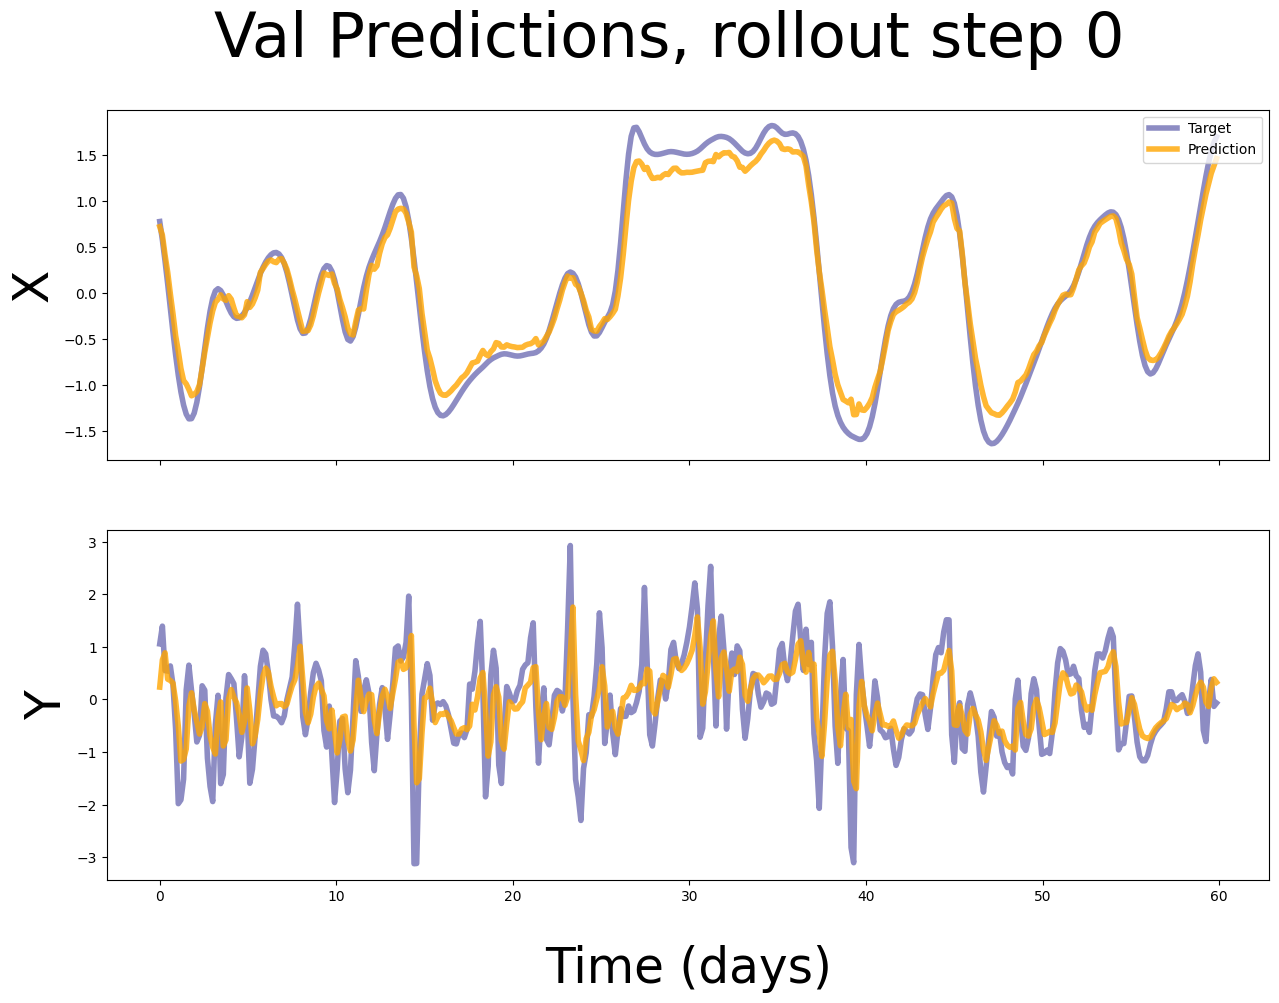

In [185]:
plot_predictions(
    config=config,
    workdir=workdir, # for loading checkpoints 
    plot_ith_rollout_step=0, # 0 indexed # for this study, we have a 4-step rollout 
    # dataset,
    # preds,
    # timestep_duration,
    # n_rollout_steps,
    #  total_steps,
    node=0, # 0-indexed 
    plot_mode="val", # i.e. "train"/"val"/"test"
    plot_days=60,
    title="Val Predictions, rollout step 0"
)

Now if you go to the workdir folder, you can see the checkpoints and tensorboard objects it created. Also notice in the logs that the loss gets better over the (two) epochs we trained for! 

### HYPERPARAMETER TUNING

We use the `optuna` library for hyperparameter tuning, which is a flexible framework that can work with any ML library we use. 

terminology:
* objective function: a function that returns the value you want to optimize (for example, an entire training pipeline, which trains a model for X epochs and returns the final validation loss. We want to minimize the loss by the end of training, and we need to tune the hyperparameters to do so.)
* Parameter: A variable whose value is to be optimized. can be continuous, discrete, categorical, etc. (e.g. learning rate, number of GNBlocks chained together, choice of activation function, etc.)
* Trial: An object which is like a single run of the objective function; in each trial, optuna generates different parameters.
* Study: An optimization session, which is a set of trials. parameters vary across trials, and we can choose the best set of hyperparams by the end of the study. 

This tutorial explains how things work in more depth: https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/guide4/Research_Projects_with_JAX.html#Automatic-hyperparameter-tuning-with-Optuna 


Here is an example run: 

In [186]:
import optuna 
from utils.jraph_training import train_and_evaluate_with_data, create_dataset
import os 
from functools import partial

CHECKPOINT_PATH = 'experiments/tuning'

define the objective function: 

In [187]:
def objective(trial, study_name, datasets):
    """ Defines the objective function to be optimized over, aka the validation loss of a model.
    
        Args:
            trial: object which characterizes the current run 
            datasets: dictionary of data. we explicitly pass this in so that we don't have to waste runtime regenerating the same dataset over and over. 
    """
    # create config 
    config = ml_collections.ConfigDict()

    config.n_samples=5000
    config.input_steps=1
    config.output_delay=0 # predict 0 hours into the future
    config.output_steps=4
    config.timestep_duration= 3
    config.sample_buffer=-1 * (config.input_steps + config.output_delay + config.output_steps - 1) # negative buffer so that our sample input are continuous (i.e. the first sample would overlap a bit with consecutive samples) 
    config.time_resolution=120
    config.init_buffer_samples=0
    config.train_pct=0.7
    config.val_pct=0.2
    config.test_pct=0.1
    config.K=36
    config.F=8
    config.c=10
    config.b=10
    config.h=1
    config.seed=42
    config.normalize=True
    config.fully_connected_edges=False
    config.max_checkpts_to_keep=None # none means all
    # Optimizer.
    # config.optimizer = "adam"
    config.optimizer = trial.suggest_categorical("optimizer", ["adam", "sgd"])
    config.learning_rate = trial.suggest_float('learning_rate', 3e-4, 3e-3, 
                                               log=True)
    if config.optimizer == "sgd":
        config.momentum = trial.suggest_float('momentum', 0, 0.999) # upper bound is inclusive, and we want to exclude a momentum of 1 because that would yield no decay 

    # Training hyperparameters.
    config.batch_size = 1 # variable currently not used
    config.epochs = 150
    config.log_every_epochs = 5
    config.eval_every_epochs = 5
    config.checkpoint_every_epochs = 10

    # GNN hyperparameters.
    config.model = 'MLPGraphNetwork'
    config.n_blocks = trial.suggest_int('n_blocks', 1, 3)
    config.share_params = False
    config.dropout_rate = trial.suggest_float('dropout_rate', 0, 0.2)
    config.skip_connections = False # This was throwing a broadcast error in add_graphs_tuples_nodes when this was set to True
    config.layer_norm = False # TODO perhaps we want to turn on later
    config.activation = trial.suggest_categorical(
        'activation', ["relu", "elu", "leaky_relu"])
    # config.activation = "leaky_relu"
    
    config.pred_x1 = True
    config.pred_x2 = True

    if config.pred_x1 and config.pred_x2:
        output_layer = 2
    else:
        output_layer = 1

    # choose the hidden layer feature size using powers of 2 
    config.edge_features = (
        2**trial.suggest_int("edge_mlp_1_power", 1, 3), # range 2 - 8; upper bound is inclusive
        2**trial.suggest_int("edge_mlp_2_power", 1, 3), # range 2 - 8
    )
    config.node_features = (
        2**trial.suggest_int("node_mlp_1_power", 1, 6), 
        # 2**trial.suggest_int("node_mlp_2_power", 1, 6), 
        output_layer) 
    # note the last feature size will be the number of features that the graph predicts
    config.global_features = None

    # generate a workdir 
    # TODO: check if we actually care about referencing this in the future or if we can just create a temp dir 
    workdir=os.path.join(CHECKPOINT_PATH, study_name, f"trial_{trial.number}")

    # run training 
    state, train_metrics, eval_metrics_dict = train_and_evaluate_with_data(config=config, workdir=workdir, datasets=datasets, trial=trial)
    
    # retrieve and return val loss (MSE)
    return eval_metrics_dict['val'].compute()['loss']

In [188]:
# generate dataset 
datasets = create_dataset(config)

In [189]:
def prepare_study(study_name):
    # get the objective function that reuses the pre-generated datasets 
    objective_partial = partial(objective, study_name=study_name, 
                                datasets=datasets)

    # run optimization study
    db_path = os.path.join(CHECKPOINT_PATH, study_name, "optuna_hparam_search.db")
    if not os.path.exists(os.path.join(CHECKPOINT_PATH, study_name)):
        os.makedirs(os.path.join(CHECKPOINT_PATH, study_name))

    study = optuna.create_study(
        study_name=study_name,
        storage=f'sqlite:///{db_path}', # generates a new db if it doesn't exist
        direction='minimize',
        pruner=optuna.pruners.MedianPruner(
            n_startup_trials=5, 
            n_warmup_steps=50,
            ), 
        load_if_exists=True, 
    )
    
    return study, objective_partial

Create the study. Then run the optimization. 

In [210]:
# create the study
study, objective_partial = prepare_study(study_name="seperate_forcing2")

[I 2024-06-27 13:34:58,808] A new study created in RDB with name: seperate_forcing2


In [211]:
# turn off logging because it'll get annoying 
logger.setLevel(logging.WARNING)

In [212]:
# run the optimization 
study.optimize(objective_partial, 
                n_trials=5-len(study.trials), 
                n_jobs=1)

[I 2024-06-27 13:37:26,954] Trial 0 finished with value: 0.8149217367172241 and parameters: {'optimizer': 'adam', 'learning_rate': 0.0019595207600902834, 'n_blocks': 1, 'dropout_rate': 0.11361831161556575, 'activation': 'leaky_relu', 'edge_mlp_1_power': 1, 'edge_mlp_2_power': 3, 'node_mlp_1_power': 5}. Best is trial 0 with value: 0.8149217367172241.
[I 2024-06-27 13:39:35,761] Trial 1 finished with value: 0.6859319806098938 and parameters: {'optimizer': 'sgd', 'learning_rate': 0.0005476620899432323, 'momentum': 0.2913465010290649, 'n_blocks': 1, 'dropout_rate': 0.03363324159764405, 'activation': 'elu', 'edge_mlp_1_power': 3, 'edge_mlp_2_power': 1, 'node_mlp_1_power': 2}. Best is trial 1 with value: 0.6859319806098938.
[I 2024-06-27 13:39:41,130] Trial 2 pruned. 
[I 2024-06-27 13:42:04,088] Trial 3 finished with value: 0.4056090712547302 and parameters: {'optimizer': 'sgd', 'learning_rate': 0.00045346796177033903, 'momentum': 0.8712873602503628, 'n_blocks': 1, 'dropout_rate': 0.01328704

Then we can look at the different trials in the study and choose the best one. 

In [213]:
study.trials

[FrozenTrial(number=0, state=1, values=[0.8149217367172241], datetime_start=datetime.datetime(2024, 6, 27, 13, 35, 1, 96819), datetime_complete=datetime.datetime(2024, 6, 27, 13, 37, 26, 948717), params={'optimizer': 'adam', 'learning_rate': 0.0019595207600902834, 'n_blocks': 1, 'dropout_rate': 0.11361831161556575, 'activation': 'leaky_relu', 'edge_mlp_1_power': 1, 'edge_mlp_2_power': 3, 'node_mlp_1_power': 5}, user_attrs={}, system_attrs={}, intermediate_values={0: 2.677945137023926, 5: 0.889523446559906, 10: 0.8353498578071594, 15: 0.8422384262084961, 20: 0.8311452269554138, 25: 0.8489133715629578, 30: 0.8351394534111023, 35: 0.822145402431488, 40: 0.8207212686538696, 45: 0.8403655290603638, 50: 0.8366326689720154, 55: 0.8292922973632812, 60: 0.8221315145492554, 65: 0.8328268527984619, 70: 0.8253820538520813, 75: 0.8496912717819214, 80: 0.8085540533065796, 85: 0.826089084148407, 90: 0.8325895667076111, 95: 0.8399433493614197, 100: 0.8377991914749146, 105: 0.8466002941131592, 110: 0.8

In [214]:
from utils.hyperparam_tuning import get_best_trial_config, get_best_trial_workdir

Checkpoint directory: /Users/miamirabelli/Desktop/GNN Research/lorenzGNN/experiments/tuning/seperate_forcing2/trial_3/checkpoints


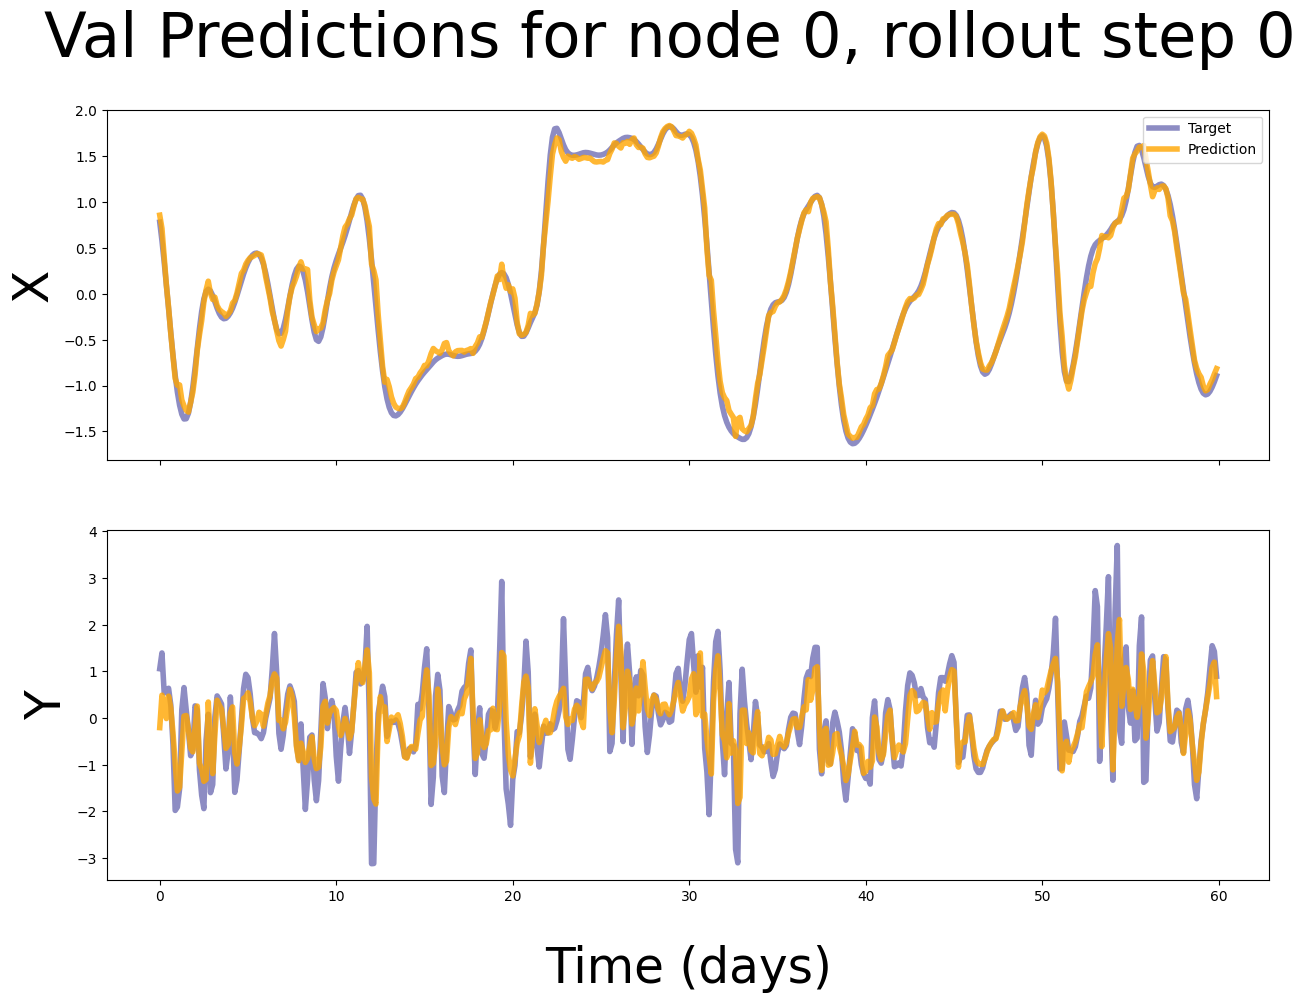

In [216]:
plot_predictions(
    config=get_best_trial_config(study=study),
    workdir=get_best_trial_workdir(study=study), # for loading checkpoints 
    plot_ith_rollout_step=0, # 0 indexed # for this study, we have a 4-step rollout 
    # dataset,
    # preds,
    # timestep_duration,
    # n_rollout_steps,
    #  total_steps,
    node=0, # 0-indexed 
    plot_mode="val", # i.e. "train"/"val"/"test"
    datasets=datasets,
    plot_days=60,
    title="Val Predictions for node 0, rollout step 0"
)

In [223]:
current = get_best_trial_config(study=study)
print(f"optimizer:", current.optimizer)
print(f"learning rate:", current.learning_rate)
print(f"n blocks:", current.n_blocks)
print(f"dropout rate:", current.dropout_rate)
print(f"activation:", current.activation)
print(f"edge features:", current.edge_features)
print(f"node features:", current.node_features)
print(f"momentum", current.momentum)
print("---------------------------------------")

optimizer: sgd
learning rate: 0.00045346796177033903
n blocks: 1
dropout rate: 0.013287043114620523
activation: relu
edge features: (8, 8)
node features: (32, 2)
momentum 0.8712873602503628
---------------------------------------


In [198]:
from utils.jraph_training import train_and_evaluate_with_data, create_dataset, evaluate_model, rollout
# from utils.jraph_models import MLPGraphNetwork
from utils.jraph_data import print_graph_fts
from utils.jraph_vis import plot_predictions
from utils.hyperparam_tuning import remove_bad_trials, get_best_trial_config, get_best_trial_workdir
import ml_collections
import optuna 
from flax import linen as nn
from functools import partial
from datetime import datetime
import os 
import tempfile
import matplotlib.pyplot as plt 
import numpy as np 

import jax
from utils.jraph_training import create_dataset, create_model, create_optimizer
from clu import checkpoint
from clu import parameter_overview
from flax.training import train_state



In [218]:
def plot_predictions_multirollout(
    config,
    workdir, # for loading checkpoints 
    node, # 0-indexed 
    plot_mode, # i.e. "train"/"val"/"test"
    datasets=None,
    plot_days=None, # if None, plot entire time series; otherwise plot specified number of days 
    title=''):
    assert plot_mode in ["train", "val", "test"]

    checkpoint_dir = os.path.join(workdir, 'checkpoints')
    assert os.path.exists(checkpoint_dir)

    # samples must be overlapping and consecutive for this plot to really be interpretable the way it is meant 
    assert (
        config.input_steps + config.output_delay + config.output_steps + config.sample_buffer == 1
        )

    # Get datasets, organized by split.
    if datasets is None:
        logging.info('Generating datasets from config because none provided.')
        datasets = create_dataset(config)

    plot_set = datasets[plot_mode]
    input_data = plot_set['inputs']
    target_data = plot_set['targets']
    # n_rollout_steps = config.output_steps

    # Create the evaluation state, corresponding to a deterministic model.
    logging.info('Initializing network.')
    rng = jax.random.key(0)
    rng, init_rng = jax.random.split(rng)
    sample_input_window = input_data[0]
    eval_net = create_model(config, deterministic=True)
    params = jax.jit(eval_net.init)(init_rng, sample_input_window)
    parameter_overview.log_parameter_overview(params) # logs to logging.info

    # Create the optimizer and state.
    # (we don't actually need the optimizer for evaluation, we just need it to create the state)
    tx = create_optimizer(config)
    state = train_state.TrainState.create(
        apply_fn=eval_net.apply, params=params, tx=tx
    )

    # load the checkpoint state
    ckpt = checkpoint.Checkpoint(checkpoint_dir)
    state = ckpt.restore(state) # restore latest checkpoint 

    # get the predictions from the model for the ith step of the rollout and for the specified node
    node_preds_all_rollouts = []
    node_targets = []

    # loop over individual windows in the dataset 
    # TODO try batching to see if its faster? 

    if plot_days is not None:
        plot_count = plot_days * config.time_resolution / 5 / config.timestep_duration
    else:
        plot_count = len(input_data)

    for i, (input_window_graphs, target_window_graphs) in enumerate(zip(
        input_data, target_data)):
        if i >= plot_count:
            break
        pred_nodes_list = rollout(state=state,
                                  input_window_graphs=input_window_graphs,
                                  n_rollout_steps=config.output_steps,
                                #   n_rollout_steps=plot_ith_rollout_step+1, # +1 since plot_ith_rollout_step is 0-indexed
                                  rngs=None) # deterministic during eval
        
        # get the last array of predictions, which will correspond to the ith rollout step that we care about 
        # ith_rollout_pred = pred_nodes_list[plot_ith_rollout_step]
        # node_pred = ith_rollout_pred[node, :] # jnp array with shape (1, 2)
        node_preds_all_rollouts.append([ith_rollout_pred[node, :] for ith_rollout_pred in pred_nodes_list])

        # also grab the target nodes while we're in this loop 
        # ith_rollout_target = target_window_graphs[plot_ith_rollout_step].nodes
        node_target = target_window_graphs[0].nodes[node, :] # jnp array with shape (1, 2)
        node_targets.append(node_target)
        # node_targets.append([ith_rollout_target.nodes[node, :] for ith_rollout_target in target_window_graphs])

    node_preds_all_rollouts = np.array(node_preds_all_rollouts) # shape (len(t_days), output_steps, 2)
    node_targets = np.array(node_targets) # shape (len(t_days), 2)

    # reconstruct timesteps
    steps = np.arange(plot_count)
    # convert timesteps from step index to day 
    t_days = steps * config.timestep_duration * 5 / config.time_resolution 

    # set up plot
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(20, 8))
    if title == '':
        fig.suptitle(f"{plot_mode} predictions for node {node}", size=28)
    else:
        fig.suptitle(title, size=28)
    ax0.set_title("X1 (i.e. oceanic variable) for node {}".format(node),
                  size=20)
    ax1.set_title("X2 (i.e. atmospheric variable) for node {}".format(node),
                  size=20)
    plt.xlabel('time (days)', size=16)

    # plot rollout targets
    ax0.plot(
        t_days,
        node_targets[:, 0],
        # s=5,
        alpha=0.8,
        label='targets',
        c='blue')
    ax1.plot(
        t_days,
        node_targets[:, 1], 
        alpha=0.8, 
        label='targets', 
        c='blue')

    # plot predictions
    for i in range(config.output_steps):
        rollout_steps = np.arange(i, plot_count + i)
        t_days_rollout = rollout_steps * config.timestep_duration * 5 / config.time_resolution 
        ax0.plot(
            t_days_rollout,
            node_preds_all_rollouts[:, i, 0],
            # s=5,
            alpha=0.8,
            label=f'rollout {i}')
        ax1.plot(
            t_days_rollout,
            node_preds_all_rollouts[:, i, 1],
            # s=5,
            alpha=0.8,
            label=f'rollout {i}')

    ax0.legend()
    ax1.legend()


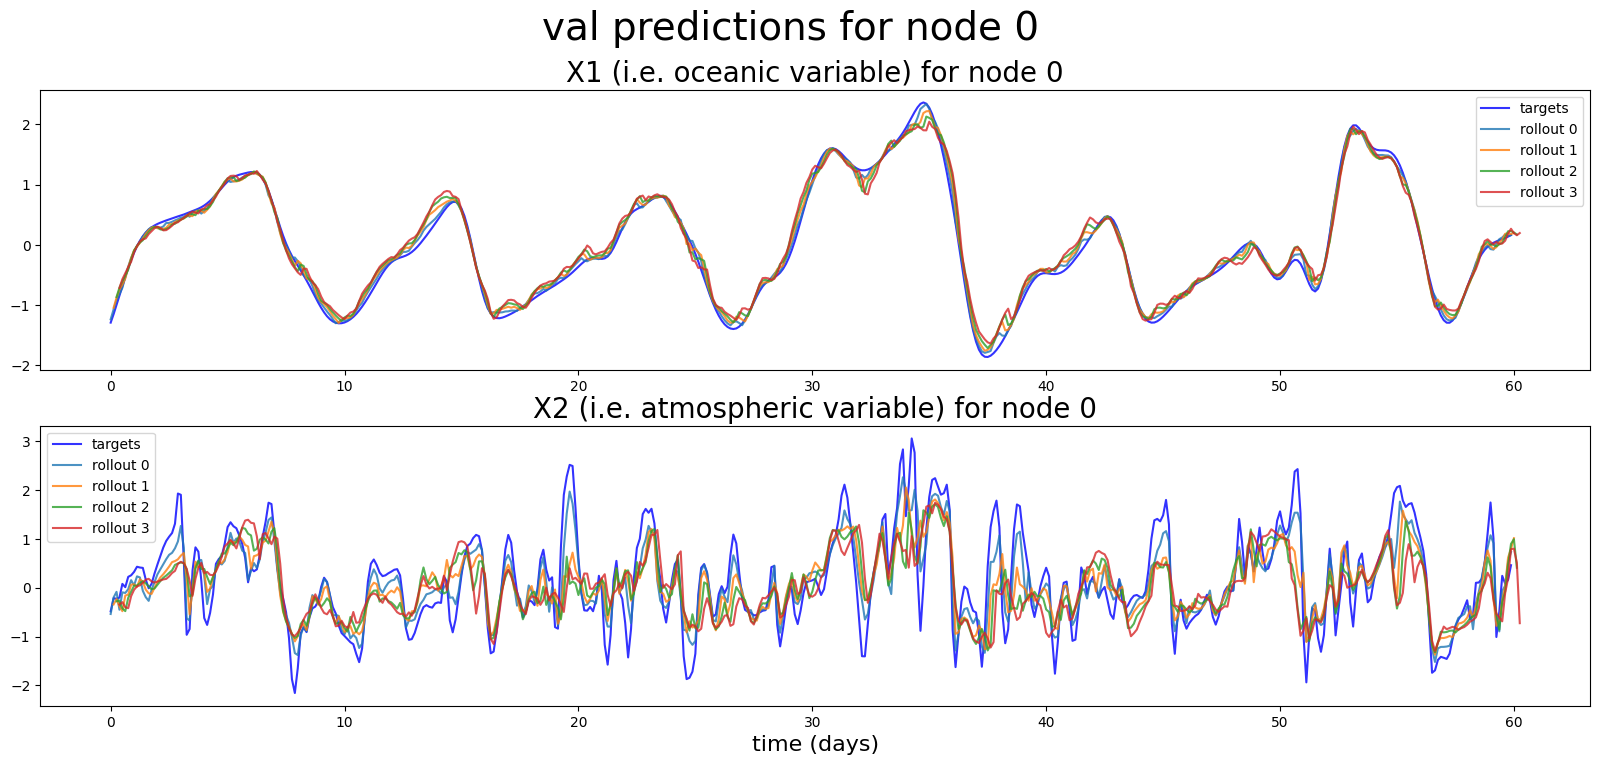

In [219]:
plot_predictions_multirollout(
        config=get_best_trial_config(study=study),
        workdir=get_best_trial_workdir(study=study),
        node=0, # 0-indexed 
        plot_mode="val", # i.e. "train"/"val"/"test"
        plot_days=60
    )

### Closing Remarks

Library documentation that I had to reference a lot: 

* [jraph](https://jraph.readthedocs.io/en/latest/index.html)
* [jax](https://jax.readthedocs.io/en/latest/index.html)
* [flax](https://flax.readthedocs.io/en/latest/)
* [optuna](https://optuna.readthedocs.io/en/stable/index.html)